In [15]:
import os
import gc
import pickle
import h5py
import numpy as np
import quimb as qu
from sklearn import svm
import quimb.tensor as qtn
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from Haldane_anis_supervise_class import *

In [16]:
L = 5 #number of particles must be odd
keep = [1,2,3]
bond = 10 # resonable amount
path  = f"./dataset_L={L}_bond={bond}_partial"
os.makedirs(path, exist_ok=True)

In [17]:
points = Haldan_anis(L = L, bond = bond).points()
file_path_train_DMRG = os.path.join(path, 'train_set_DMRG.pkl')
with open(file_path_train_DMRG, "wb") as f:
    pickle.dump(points, f)
gc.collect(2)

14374

In [18]:
def gram_train_DMRG_partial():

    with open(file_path_train_DMRG, 'rb') as f:
        loaded_dataset = pickle.load(f)

    gs = loaded_dataset[0]

    d = len(gs)
    gram = np.zeros((d,d))

    partial_rho = [gs[i].partial_trace_to_mpo( keep=keep, rescale_sites=True) for i in range(d)]

    for idx in range(d*d):
        i = idx // d
        j = idx % d
        if j >= i:
            gram[i,j]=gram[j,i]=  partial_rho[i]@partial_rho[j]

    return gram

g_train_partial = gram_train_DMRG_partial()

file_path_kernel_train_DMRG= os.path.join(path, "kernel_train_Haldane_DMRG_partial.hdf5")
with h5py.File(file_path_kernel_train_DMRG, "w") as f:
    f.create_dataset(" gram_train_DMRG_partial", data = g_train_partial)
    
gc.collect(2)

0

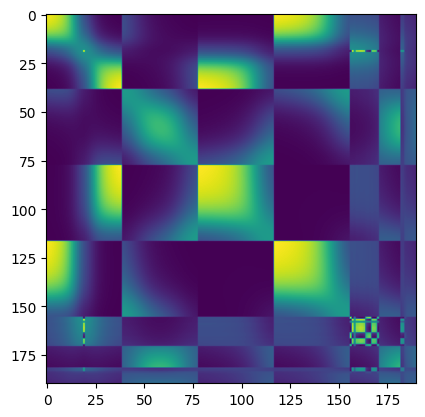

In [19]:
plt.imshow(g_train_partial)

In [20]:
test = Haldan_anis(L = L, bond = bond).generate_test_set()
file_path_test = os.path.join(path, 'test_set.pkl')
with open(file_path_test, "wb") as f:
    pickle.dump(test, f)
gc.collect(2)

26

In [21]:
with open(file_path_test, 'rb') as f:
    loaded_test_set = pickle.load(f)  
Xte = np.array(loaded_test_set)
d1 = Xte.shape[0]

with open(file_path_train_DMRG, "rb") as f:
    loaded_dataset = pickle.load(f)
Xtr = np.array(loaded_dataset[0])
d2 = Xtr.shape[0]
    
partial_rhos_test = [Xte[i].partial_trace_to_mpo( keep=keep, rescale_sites=True) for i in range(d1)]
partial_rhos_train = [Xtr[i].partial_trace_to_mpo( keep=keep, rescale_sites=True) for i in range(d2)]

In [26]:
len(partial_rhos_test)

1600

In [28]:
def gram_test_DMRG_partial():

    gram_matrix_test = np.zeros((d1,d2))
    for i in range(d1):
        for j in range(d2):
            gram_matrix_test[i,j]=partial_rhos_test[i] @ partial_rhos_train[j]

    return gram_matrix_test

In [29]:
g_test = gram_test_DMRG_partial()


In [30]:

file_path_kernel_test_DMRG = os.path.join(path, "kernel_test_Haldane_DMRG_partial.hdf5")
with h5py.File(file_path_kernel_test_DMRG, "w") as f:
    f.create_dataset("gram_test_partial", data = g_test)
gc.collect(2)

1158

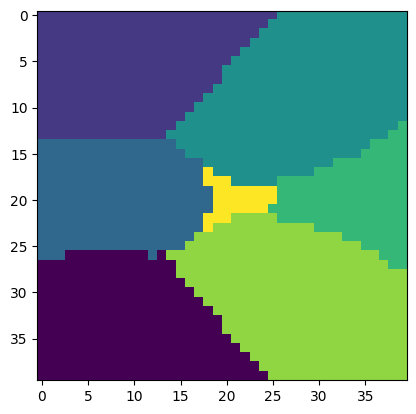

In [31]:
clf = svm.SVC(kernel='precomputed')
with open(file_path_train_DMRG, "rb") as f:
    dataset = pickle.load(f)

'''with h5py.File(file_path_kernel_train_DMRG, "r") as f:
    kernel_train = f[" gram_train_DMRG"][:] 

with h5py.File(file_path_kernel_test_DMRG, "r") as f:
    kernel_test = f["gram_test"][:] '''
kernel_train = g_train_partial
kernel_test = g_test
y = dataset[1]
clf.fit(kernel_train, y) 
y_pred = clf.predict(kernel_test)
plt.imshow(y_pred.reshape(40,40))
plt.savefig(f'result for DMRG states with L={L} and bond dimension ={bond}.png')
plt.show()

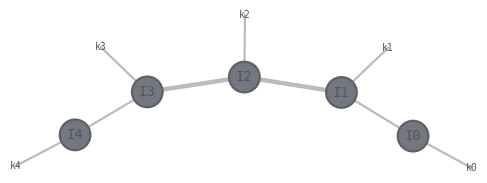

In [ ]:
DMRG0 = points[0][0]
DMRG1 = points[0][1]

DMRG0.draw()

In [51]:
DMRG0

MatrixProductState(tensors=5, indices=9, L=5, max_bond=9)

In [71]:
rho_13_0 = DMRG0.partial_trace_to_mpo(
    keep=[1,2,3],
    rescale_sites=True  
)

rho_dense = rho_13_0.to_dense()

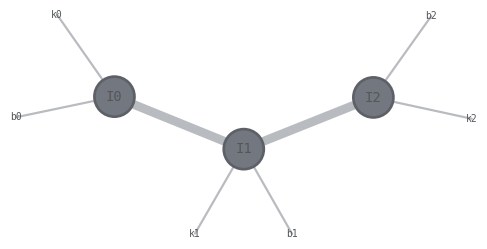

In [72]:
rho_13_0.draw()

In [73]:
rho_13_1 = DMRG1.partial_trace_to_mpo(
    keep=[1,2,3],
    rescale_sites=True  
)

rho_dense = rho_13_1.to_dense()

In [75]:
rho_13_0@rho_13_1

0.8456970526425062